In [1]:
import time
import requests
import pandas as pd
from datetime import datetime, date, time as dt_time, timedelta
from zoneinfo import ZoneInfo
from IPython.display import clear_output
import requests
import pandas_ta as ta
from rdp import rdp
import talib
import numpy as np
import pandas_ta as ta
from scipy.stats import zscore
from scipy.signal import savgol_filter

from datetime import datetime, date, time as dt_time, timedelta
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# ── CONFIG ─────────────────────────────────────────────────────────────────
API_KEY = "vBRy5un9PuHfxFj1IrHpfg8a2RS57jE9"

# https://github.com/polygon-io/client-python/blob/master/examples/websocket/stocks-ws.py

In [2]:
def fetch_polygon_data(ticker: str, api_key: str,
                              start_date: date,
                              end_date: date,
                              start_time: dt_time,
                              end_time: dt_time = dt_time(16, 0),
                              multiplier: int = 1,
                              timespan: str = "minute",
                              limit: int = 50000) -> pd.DataFrame:
    """
    Fetches intraday minute-level OHLCV data for a given ticker from Polygon.io.

    Args:
        ticker (str): Stock ticker symbol (e.g., "TSLA").
        api_key (str): Your Polygon.io API key.
        start_date (date): The date for which to fetch data.
        end_date (date): The date for which to end fetch data.
        start_time (datetime.time): Start of time window in EST.
        end_time (datetime.time): End of time window in EST.
        multiplier (int): Interval multiplier (default 1 minute).
        timespan (str): Time unit ("minute", "hour", etc.).
        limit (int): Maximum number of results to retrieve.

    Returns:
        pd.DataFrame: A filtered DataFrame with renamed columns and timestamps in EST.
    """
    ET_ZONE = ZoneInfo("America/New_York")

    url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/{multiplier}/{timespan}/{start_date}/{end_date}"
    params = {
        "apiKey": api_key,
        "adjusted": "true",
        "sort": "asc",
        "limit": limit
    }

    session = requests.Session()
    response = session.get(url, params=params)
    response.raise_for_status()

    bars = response.json().get("results", [])
    df = pd.DataFrame(bars)

    if df.empty:
        return pd.DataFrame()  # Return empty DataFrame if no data

    df["TIME_UTC"] = pd.to_datetime(df["t"], unit="ms", utc=True)
    df["TIME_EST"] = df["TIME_UTC"].dt.tz_convert(ET_ZONE)
    del df["TIME_UTC"]

    # Define time window
    start_dt = datetime.combine(start_date, start_time, tzinfo=ET_ZONE)
    end_dt = datetime.combine(end_date, end_time, tzinfo=ET_ZONE)

    # Filter and rename
    df = df[(df["TIME_EST"] >= start_dt) & (df["TIME_EST"] <= end_dt)].copy()
    df.rename(columns={
        "o": "open",
        "h": "high",
        "l": "low",
        "c": "close",
        "v": "volume",
        "n": "trades",
        "vw": "vwap"
    }, inplace=True)

    return df


In [3]:

def add_candlestick_patterns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds all TA-Lib candlestick pattern columns and a summary column with detected patterns.
    
    Returns:
        DataFrame with candlestick pattern columns and a 'Detected_Patterns' summary column.
    """
    # Build dictionary of candlestick pattern functions
    cdl_patterns = {
        func: getattr(talib, func)
        for func in dir(talib)
        if func.startswith("CDL")
    }

    # Apply each pattern function to the OHLC data
    for name, pattern_func in cdl_patterns.items():
        try:
            df[name] = pattern_func(df['open'], df['high'], df['low'], df['close'])
        except Exception as e:
            print(f"⚠️ Could not compute {name}: {e}")
            df[name] = 0  # Fallback to 0 if something fails

    # Detect and summarize patterns per row
    def detect_patterns(row):
        patterns = []
        for name in cdl_patterns:
            val = row[name]
            if val != 0:
                direction = "Bullish" if val > 0 else "Bearish"
                strength = abs(val)
                patterns.append(f"{name} ({direction}, Strength={strength})")
        return ', '.join(patterns) if patterns else None

    # Add summary column
    df["Detected_Patterns"] = df.apply(detect_patterns, axis=1)

    return df

In [4]:


def add_indicators_and_signals(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds technical indicators, buy conditions, and entry signal column to the given DataFrame.
    Assumes columns: 'open', 'high', 'low', 'close', 'volume'


    Returns:
        DataFrame with new columns added.
    """

    # Bollinger Bands_________________________________________________________
    # ________________________________________________________________________

    up, _, dn = talib.BBANDS(df.close.values, timeperiod=20, nbdevup=2, nbdevdn=2)
    df['BB_up_2'], df['BB_dn_2'] = up, dn

    up, _, dn = talib.BBANDS(df.close.values, timeperiod=20, nbdevup=1, nbdevdn=1)
    df['BB_up_1'], df['BB_dn_1'] = up, dn

    # VWAP (Cumulative approximation)_________________________________________
    # ________________________________________________________________________

    start_time = dt_time(4, 0)   # ex.,4:00 AM ET
    end_time = dt_time(16, 0)  

    mask = (df['TIME_EST'].dt.time >= start_time) & (df['TIME_EST'].dt.time <= end_time)
    df_trading = df.loc[mask].copy()

    df.loc[mask, 'VWAP_Cum'] = ((df.loc[mask, 'close'] * df.loc[mask, 'volume']).groupby(df.loc[mask, 'TIME_EST'].dt.date).cumsum()
                                /
                                df.loc[mask, 'volume'].groupby(df.loc[mask, 'TIME_EST'].dt.date).cumsum())

    # EMA, MACD, ATR, SMA ____________________________________________________
    # ________________________________________________________________________

    macd, sig, hist = talib.MACD(df.close.values, fastperiod=12, slowperiod=26, signalperiod=9)
    df['MACD'], df['Signal'], df['MACD_hist'] = macd, sig, hist

    # EMA, MACD, ATR, SMA     ----------------------------
    df['EMA9'] = talib.EMA(df.close.values, timeperiod=9)
    df['EMA20'] = talib.EMA(df.close.values, timeperiod=20)
    df['EMA50'] = talib.EMA(df.close.values, timeperiod=50)
    df['EMA200'] = talib.EMA(df.close.values, timeperiod=200)

    macd, sig, hist = talib.MACD(df.close.values, fastperiod=12, slowperiod=26, signalperiod=9)
    df['MACD'], df['Signal'], df['MACD_hist'] = macd, sig, hist

    df['ATR'] = talib.ATR(df.high.values, df.low.values, df.close.values, timeperiod=14)
    df['SMA5'] = talib.SMA(df.close.values, timeperiod=5)
    df['SMA20'] = talib.SMA(df.close.values, timeperiod=20)
    df['SMA50'] = talib.SMA(df.close.values, timeperiod=50)
    df['SMA200'] = talib.SMA(df.close.values, timeperiod=200)

    # RSI                     ----------------------------  
    df['RSI'] = talib.RSI(df.close.values, timeperiod=14)
    
    # TSI                     ________________________________________________
    # ________________________________________________________________________

    tsi_df = ta.tsi(df['close'], long=25*4, short=13*4, signal=8*4)
    tsi_df.index = df.index  # Align index to match df
    tsi_df.columns = ['TSI', 'TSI_signal']
    df = df.join(tsi_df)
    
    # Confriming Signal_______________________________________________________
    # ________________________________________________________________________
    
    df['SMA200_VL']=df['SMA200'].diff()
    df['SMA50_VL']=df['SMA50'].diff()

    zscored_signal = zscore(df[['SMA50_VL','SMA200_VL']].values, axis=0, ddof=0, nan_policy='omit')
    df[['SMA50_VL_ZSCR', 'SMA200_VL_ZSCR']] = zscored_signal


    # smoothed Signal         ----------------------------
    df['SMA50_VL_smooth'] = savgol_filter(df['SMA50_VL'], window_length=70, polyorder=3)
    df['SMA200_VL_smooth'] = savgol_filter(df['SMA200_VL'], window_length=70, polyorder=3)

    zscored_signal= zscore(df[['SMA50_VL_smooth','SMA200_VL_smooth']].values, axis=0, ddof=0, nan_policy='omit')
    df[['SMA50_VL_ZSCR_smooth', 'SMA200_VL_ZSCR_smooth']] = zscored_signal

    # ZigZag Signal           ----------------------------
    valid_mask = df['SMA200_VL_ZSCR'].notna()
    x = np.arange(len(df))[valid_mask]
    y = df['SMA200_VL_ZSCR'][valid_mask].values

    points = np.vstack((x, y)).T
    simplified_points = rdp(points, epsilon=1.75)

    # interpolate across full range
    simplified_signal = np.interp(np.arange(len(df)), simplified_points[:,0], simplified_points[:,1])
    df['SMA200_VL_ZSCR_rdp'] = simplified_signal


    valid_mask = df['SMA50_VL_ZSCR'].notna()
    x = np.arange(len(df))[valid_mask]
    y = df['SMA50_VL_ZSCR'][valid_mask].values

    points = np.vstack((x, y)).T
    simplified_points = rdp(points, epsilon=1.75)

    # interpolate across full range
    simplified_signal = np.interp(np.arange(len(df)), simplified_points[:,0], simplified_points[:,1])
    df['SMA50_VL_ZSCR_rdp'] = simplified_signal

    

    # Buy Conditions__________________________________________________________
    # ________________________________________________________________________
    df["ATR_pct"] = df["ATR"] / df["close"]
    df["MACD_amplified"] = (df["MACD"].abs() > 2 * df["Signal"].abs().rolling(window=20).mean())
    df['VWAP_change'] = df['VWAP_Cum'].diff()
    df["MACD_hist_smooth_EMA"] = df["MACD_hist"].ewm(span=5, adjust=False).mean()


    df['VWAP_pct_change'] = df['VWAP_Cum'].pct_change()
    df['VWAP_slope'] = df['VWAP_Cum'].rolling(window=5).apply(slope, raw=False)

    # ─────────────── BUY SEGMENT ───────────────
    buy_condition = (
        (df["close"] > df["VWAP_Cum"]) &
        (df["SMA50"] > df["SMA200"]) &
        (df["VWAP_Cum"] > df["SMA200"]) &
        (df["MACD_hist_smooth_EMA"].diff() > 0) &
        (df["MACD_hist"] > 0) &
        (df["RSI"].diff() > 0) 
        & (df["ATR_pct"] > 0.001) 
        & (df["MACD_amplified"])
        & (df['VWAP_change'] > 0.01)
        & (df["SMA200"].diff() > 0) 
    )

    df["buy_condition"] = buy_condition

    # ─────────────── SELL SEGMENT ────────────────────────────
    df['was_above'] = df['close'].shift(1) > df['EMA50'].shift(1)
    df['is_below'] = df['close'] <= df['EMA50']
    df['Sell_condition'] = df['was_above'] & df['is_below']

   # -----Nullify any Sell that happens before the first Buy and after the last buy ------

    if df['buy_condition'].any():

        # ptu Sell as False before the first Buy 
            df.loc[~df['buy_condition'].cummax(), 'Sell_condition'] = False

            # find the index of the last Buy
            last_buy_idx = df.index[df['buy_condition']].max()

            # find the first Sell after last Buy index
            first_sell_idx = df.loc[last_buy_idx + 1:, 'Sell_condition'].idxmax()
            
            # mask all sells, then re-enable only that first one
            df.loc[df.index > first_sell_idx, 'Sell_condition'] = False

    return df
    

In [5]:
from datetime import date
import time
from typing import List, Dict

def fetch_multiple_tickers_data(ticker: List[str],
                                api_key: str,
                                start_date: date,
                                end_date: date,
                                start_time: dt_time,
                                end_time: dt_time,
                                multiplier: int,
                                timespan: str,
                                limit: int ,
                                delay: float = 0.25) -> Dict[str, pd.DataFrame]:
    """
    Fetch minute-level Polygon data for multiple tickers on a given date.

    Args:
        ticker (List[str]): List of stock ticker symbols.
        api_key (str): Your Polygon.io API key.
        start_date (date): The date for which to fetch intraday data.
        delay (float): Seconds to wait between API calls (rate limit buffer).

    Returns:
        Dict[str, pd.DataFrame]: Dictionary of ticker symbol → DataFrame.
    """
    all_data = {}

    for ticker in ticker:
        try:
            df = fetch_polygon_data(
                ticker=ticker,
                api_key=API_KEY,
                start_date=start_date,
                end_date=end_date,
                start_time=start_time,
                end_time=end_time,
                multiplier=multiplier,
                timespan=timespan,
                limit=limit
                )
            if not df.empty:
                
                df = add_indicators_and_signals(df)

                all_data[ticker] = df

            print(f"✅ {ticker} - fetched {len(df)} rows")

        except Exception as e:
            print(f"❌ Error fetching {ticker}: {e}")

        time.sleep(delay) # ⏱️ Avoid hitting rate limits

    return all_data


In [6]:
from sklearn.linear_model import LinearRegression


def add_tsf_forecast_to_df(df: pd.DataFrame, regression_length: int = 25, forecast_length: int = 5) -> pd.DataFrame:
    """
    Adds a Time Series Forecast (TSF) column to the DataFrame using rolling linear regression.

    Pa
    rameters:
    - df: DataFrame with 'close' column
    - regression_length: lookback window for regression
    - forecast_length: how far ahead to forecast

    Returns:
    - DataFrame with new column 'TSF_forecast'
    """
    tsf_values = [np.nan] * len(df)
    X_template = np.arange(regression_length).reshape(-1, 1)

    for i in range(regression_length, len(df) - forecast_length):
        y_window = df['close'].iloc[i - regression_length:i].values
        model = LinearRegression().fit(X_template, y_window)
        # tsf_values[i + forecast_length] = model.predict([[regression_length + forecast_length - 1]])[0]
        tsf_values[i] = model.predict([[regression_length - 1]])[0] # This is modified by farnaz  to aligne the results with


    df['TSF_forecast'] = tsf_values
    return df

from scipy.stats import linregress

def slope(series):
    x = range(len(series))
    slope, _, _, _, _ = linregress(x, series)
    return slope


In [7]:
def calc_first_buy_last_sell_pct(df,price_col='close',buy_col='buy_condition',sell_col='Sell_condition'):
    
    """
    Calculate the percent change from the first Buy to the last Sell.

    Returns:
        float: Percent gain/loss, or None if no valid buy/sell.
    """
    if not df[buy_col].any() or not df[sell_col].any():
        return None  # No valid buy or no valid sell condition

    first_buy_idx  = df.index[df[buy_col]].min()
    last_sell_idx  = df.index[df[sell_col]].max()

    buy_price  = df.at[first_buy_idx, price_col]
    sell_price = df.at[last_sell_idx, price_col]

    return (sell_price - buy_price) / buy_price * 100

In [8]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_intraday(df, ticker):
    fig = make_subplots(
        rows=6, cols=1,
        shared_xaxes=True,
        specs=[
            [{"secondary_y": True}],  # Row 1
            [{}], [{}], [{}], [{}], [{}]  # Rows 2-6
        ],
        row_heights=[0.3, 0.15, 0.15, 0.08, 0.15, 0.15],
        vertical_spacing=0.02,
        subplot_titles=("Price + BB + VWAP", "RSI5", "MACD Hist, MACD & Signal", "TSI", "V", "A")
    )

    # Row 1: Price + BB + VWAP
    fig.add_trace(go.Candlestick(
        x=df["TIME_EST"], open=df["open"], high=df["high"],
        low=df["low"], close=df["close"], name="Price"
    ), row=1, col=1, secondary_y=False)
    
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df["BB_up_1"], line=dict(dash="dash"), name="BB Up 1"), row=1, col=1)
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df["BB_dn_1"], fill="tonexty",fillcolor="rgba(200,200,200,0.2)", name="BB Dn 1"), row=1, col=1)
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df["VWAP_Cum"], line=dict(dash="dot"), name="VWAP"), row=1, col=1)
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df["EMA200"], line=dict(color="orange"), name="EMA200"), row=1, col=1)
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df["SMA200"], line=dict(color="blue"), name="SMA200"), row=1, col=1)
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df["SMA50"], line=dict(color="black"), name="SMA50"), row=1, col=1)
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df["EMA50"], line=dict(color="khaki"), name="EMA50"), row=1, col=1)
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df["SMA5"], line=dict(color="gray"), name="SMA5"), row=1, col=1)

    # Row 1: Volume zones
    df['volume_color'] = np.where(df['close'] > df['close'].shift(1), 'green',
                                  np.where(df['close'] < df['close'].shift(1), 'red', 'gray'))
    fig.add_trace(go.Bar(x=df["TIME_EST"], y=df["volume"], name="Vol",
                         marker_color=df["volume_color"], width=1000, opacity=.3, marker_line_width=0),
                  row=1, col=1, secondary_y=True)

    # Row 2: RSI5
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df["RSI"], name="RSI", line=dict(color="olive")), row=2, col=1)
    for level in [70, 50, 30]:
        fig.add_hline(y=level, line_dash="dash", row=2, col=1)

    # Row 3: MACD Histogram, MACD & Signal
    hist_colors = ['green' if val >= 0 else 'red' for val in df["MACD_hist"]]
    fig.add_trace(go.Bar(x=df["TIME_EST"], y=df["MACD_hist"],
                         marker=dict(color=hist_colors, line=dict(color=hist_colors, width=1)),
                         name='MACD Hist'), row=3, col=1)
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df['MACD'], line=dict(color='olive', width=2), name='MACD'), row=3, col=1)
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df["Signal"], line=dict(color="salmon", width=1), name="Signal"), row=3, col=1)
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df["MACD_hist_smooth_EMA"],
                             line=dict(color="brown", width=1), name="MACD_hist_smooth_EMA"), row=3, col=1)

    # Row 4: TSI
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df['TSI'], line=dict(color='red', width=2), name='TSI'), row=4, col=1)
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df['TSI_signal'], line=dict(color='blue', width=2), name='TSI_signal'), row=4, col=1)
    for level in [-25, 0, 25]:
        fig.add_hline(y=level, line_dash="dash", row=4, col=1)

    # Row 5: V-A
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df['SMA50_VL_ZSCR'], line=dict(color='black', width=1), name='SMA50_VL_ZSCR'), row=5, col=1)
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df['SMA200_VL_ZSCR'], line=dict(color='blue', width=1), name='SMA200_VL_ZSCR'), row=5, col=1)
    fig.add_hline(y=0, line_dash="dash", row=5, col=1)


    # Row 6: V-A AC
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df['SMA50_VL_ZSCR_smooth'], line=dict(color='black', width=1), name='SMA50_VL_ZSCR_smooth'), row=6, col=1)
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df['SMA200_VL_ZSCR_smooth'], line=dict(color='blue', width=1), name='SMA200_VL_ZSCR_smooth'), row=6, col=1)
    fig.add_hline(y=0, line_dash="dash", row=6, col=1)
    # fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df['SMA50_VL_ZSCR_rdp'], line=dict(color='black', width=1), name='SMA50_VL_ZSCR_rdp'), row=6, col=1)
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df['SMA200_VL_ZSCR_rdp'], line=dict(color='blue', width=1), name='SMA200_VL_ZSCR_rdp'), row=6, col=1)


    # Layout
    fig.update_layout(
        title=f"Intraday ET for {ticker} on {df['TIME_EST'].dt.date.iloc[-1]}",
        xaxis_rangeslider_visible=False,
        height=900, width=1000,
        paper_bgcolor="white", plot_bgcolor="white"
    )

    # Gridlines
    fig.update_xaxes(showgrid=True, gridcolor='lightgray', rangeslider_visible=False)
    fig.update_yaxes(showgrid=True, gridcolor='lightgray')

    # Add vertical dashed green lines at buy conditions
    if "buy_condition" in df.columns:
        for t in df.loc[df["buy_condition"], "TIME_EST"]:
            fig.add_vline(x=t, line=dict(color='green', width=1, dash='dash'))

    fig.update_layout(
        title = f"{ticker} on {df['TIME_EST'].iloc[-1].strftime('%Y-%m-%d %H:%M:%S %Z')} | Last Close: {df['close'].iloc[-1]:.2f}",

        xaxis_rangeslider_visible=False,height=900, width=1000,paper_bgcolor="white", plot_bgcolor="white")

    return fig 

    # fig.show()


In [9]:
# Add example 100 tickers

# Add example 100 tickers

TICKERS = ["AAPL", "MSFT", "GOOG", "TSLA", "AMZN", "NVDA", "META", "NFLX", "INTC", "AMD", 
           "BA", "CRM", "DIS", "ADBE", "PYPL", "CSCO", "PEP", "KO", "T", "VZ",
           "WMT", "COST", "MCD", "NKE", "QCOM", "ORCL", "IBM", "GE", "CAT", "HON",
           "JNJ", "PFE", "MRK", "LLY", "ABBV", "BMY", "CVX", "XOM", "SLB", "COP",
           "JPM", "BAC", "WFC", "GS", "MS", "BLK", "TGT", "LOW", "HD", "SBUX",
           "UBER", "LYFT", "ABNB", "SHOP", "ROKU", "ZM", "PLTR", "SNOW", "NET",
           "PANW", "CRWD", "ZS", "OKTA", "DDOG", "DOCU", "F", "GM", "RIVN", "LCID",
           "TSM", "ASML", "AVGO", "TXN", "MU", "INTU", "ADSK", "EA", "TTWO",
           "NOK", "ERIC", "V", "MA", "AXP", "PYPL", "SOFI", "HOOD", "COIN",
           "SPOT", "BIDU", "BABA", "JD", "PDD", "TME", "IQ", "YUMC", "NTES", "LI"]


TICKERS = ['SOFI','HIMS','BABA','AMD','CRWV','SRFM','HUT','BULL','CORZ','HOOD','RKLB',"GOOG", "TSLA", "AMZN", "NVDA", "META","AAPL",'PLTR']
TICKERS=['SOFI','PLTR','CRWV',"TSLA","NVDA"]

TICKERS=['MSTR','MSTU','MSTZ','ETHA','ETHT','ETHD']
TICKERS=['CRWV']
# TICKERS=['ETHD']
#ETHU 109 2x long
#ETHT 76 2x long
#SETH 8 1x short feature

/var/folders/2g/jw8wtxw938g1b33q2nygph8w0000gn/T/ipykernel_21680/3383871481.py:116: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['VWAP_pct_change'] = df['VWAP_Cum'].pct_change()


✅ CRWV - fetched 1015 rows


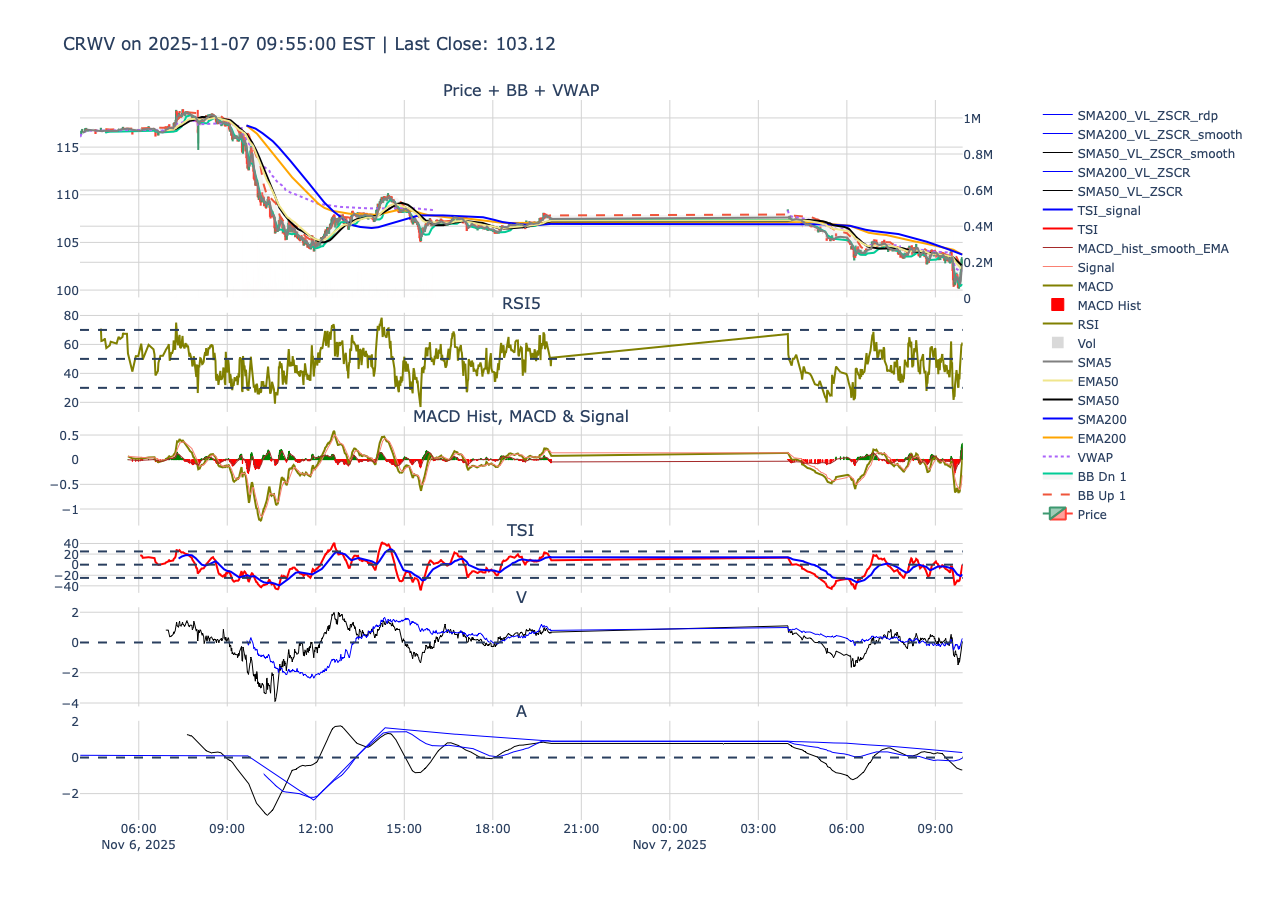

✅ All clusters with diff ≥ 0 for ≥ 5 minutes:


,run_start_close,run_end_close,delta_close,pct_change,run_start,run_end,duration_min
0,104.15,109.85,5.7,5.4729,2025-11-06 11:56:00-05:00,2025-11-06 14:27:00-05:00,151.0
1,108.41,108.61,0.2,0.1845,2025-11-06 14:53:00-05:00,2025-11-06 14:58:00-05:00,5.0



🎯 Earliest turning point: 2025-11-06 11:56:00-05:00 | close=104.1500


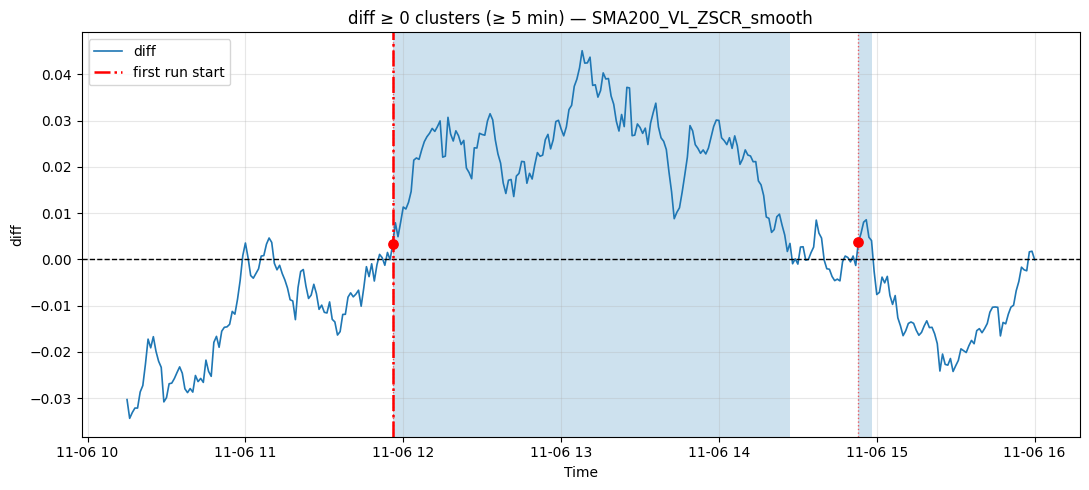

In [10]:
# Date range 
start_date = date(2025, 11, 6)
end_date = date(2025, 11, 7)

# Time window for filtering intraday bars (Eastern Time)
start_time = dt_time(0, 0)   # ex.,4:00 AM ET
end_time = dt_time(20, 0)    #ex.,4:00 PM ET
#-------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Granularity of data
multiplier = 1               #   e.g., 1-minute bars,  5-minute bars, etc.
timespan = "minute"          #  "second", "minute", "hour", "day", etc.

# Max number of bars to retrieve per request (Polygon max = 50,000)
limit = 50000

# ⬇️ Fetch intraday data for multiple tickers from Polygon
all_data_minute = fetch_multiple_tickers_data(
    ticker=TICKERS,
    api_key=API_KEY,
    start_date=start_date,
    end_date=end_date,
    start_time=start_time,
    end_time=end_time,
    multiplier=multiplier,
    timespan=timespan,
    limit=limit
)

import talib
import pandas as pd
import numpy as np
import pandas_ta as ta
from scipy.stats import zscore
from scipy.signal import savgol_filter



# TICKERS = ['BULL']

# ─────────────────────────────────────────────────────────────────────
# Assume all_data_minute is a dict: {"AAPL": df1, "TSLA": df2, ...}
# and TICKERS is your list of symbols
# ─────────────────────────────────────────────────────────────────────
TICKERS_Plot=TICKERS

all_data_minute_processed = {}

for TICKER in TICKERS_Plot:
    df = all_data_minute[TICKER].copy()

    # ─────────────── Indicators Setup ───────────────
    # EMPTY FOR NOW
    # ─────────────── Save the processed DataFrame ───────────────
    all_data_minute_processed[TICKER] = df
    #_____________________________________________________________
    
tickers_to_buy = []

for TICKER in TICKERS:
    if TICKER not in all_data_minute_processed:
        continue

    df = all_data_minute_processed[TICKER]

    # Confirm it's a DataFrame (not a tuple accidentally)
    if isinstance(df, tuple):
        df = df[0]  # if stored as (df,) in the dictionary

    if "buy_condition" in df.columns and df["buy_condition"].any():
        tickers_to_buy.append(TICKER)

# ─────────────────────────────────────────────────────────────────────
# Do the plot
# ─────────────────────────────────────────────────────────────────────

for tic in TICKERS:
    df_day = all_data_minute_processed.get(tic)
    if df_day is None or df_day.empty:
        print(f"⚠️ {tic}: no data"); 
        continue

    fig = plot_intraday(df=df_day, ticker=tic)

    # Show regardless of library
    if hasattr(fig, "show"):          # Plotly Figure or Matplotlib Figure has .show()
        fig.show()
    else:
        try:
            display(fig)              # fallback for objects with rich repr
        except Exception:
            pass

# ─────────────────────────────────────────────────────────────────────
#Find the turning points
# ─────────────────────────────────────────────────────────────────────
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ===== Inputs =====
start_time = dt_time(9, 0)   # ex.,4:00 AM ET
end_time = dt_time(16, 0)    #ex.,4:00 PM ET
start_date = date(2025, 11, 6)
end_date = date(2025, 11, 6)

time_step  = 5                                # minutes threshold for sustained positivity
TIME_COL   = "TIME_EST"
COL        = "SMA200_VL_ZSCR_smooth"
CLOSE_COL  = "close"                          # assumes df_day has 'close'
ET_ZONE = ZoneInfo("America/New_York")
# ===== Prepare window =====

df = df_day.copy()
df[TIME_COL] = pd.to_datetime(df[TIME_COL], errors="coerce")

start_time = datetime.combine(start_date, start_time, tzinfo=ET_ZONE)
end_time = datetime.combine(end_date, end_time, tzinfo=ET_ZONE)

cols_to_keep = [TIME_COL, COL] + ([CLOSE_COL] if CLOSE_COL in df.columns else [])
mask = (df[TIME_COL] >= start_time) & (df[TIME_COL] <= end_time)
df_window = (
    df.loc[mask, cols_to_keep]
      .copy()
      .set_index(TIME_COL)
      .sort_index()
)
df_window = df_window[~df_window.index.duplicated(keep="first")]

# ===== Compute diff =====
df_window["diff"] = df_window[COL].diff()

# ===== Build runs by sign ONLY (ignore timing gaps) =====
tmp = df_window["diff"].dropna().to_frame("diff").reset_index(names="ts")
tmp["grp"] = (tmp["diff"] < 0).cumsum()          # same group while diff ≥ 0
pos = tmp[tmp["diff"] >= 0]

# start/end = first/last timestamps per positive group
runs = pos.groupby("grp").agg(run_start=("ts","first"), run_end=("ts","last"))
runs["duration"] = runs["run_end"] - runs["run_start"]

# keep runs with duration >= time_step minutes
runs = runs[runs["duration"] >= pd.Timedelta(minutes=time_step)].copy()
runs["duration_min"] = runs["duration"].dt.total_seconds()/60

# ===== Attach close at run_start/run_end and compute delta/pct =====
def get_close_exact_or_asof(ts):
    if CLOSE_COL in df_window.columns:
        try:
            return float(df_window.loc[ts, CLOSE_COL])
        except KeyError:
            return float(df_window[CLOSE_COL].asof(ts))
    return np.nan

runs["run_start_close"] = runs["run_start"].map(get_close_exact_or_asof)
runs["run_end_close"]   = runs["run_end"].map(get_close_exact_or_asof)

runs["delta_close"] = runs["run_end_close"] - runs["run_start_close"]
runs["pct_change"]  = np.where(
    runs["run_start_close"] != 0,
    (runs["delta_close"] / runs["run_start_close"]) * 100.0,
    np.nan
)

# Reorder & tidy columns
runs = runs.reset_index(drop=True)
summary_cols = [
    "run_start_close", "run_end_close", "delta_close", "pct_change",
    "run_start", "run_end", "duration_min"
]
runs = runs[summary_cols]

# Round for neat display (optional)
runs_rounded = runs.copy()
runs_rounded[["run_start_close","run_end_close","delta_close","pct_change","duration_min"]] = \
    runs_rounded[["run_start_close","run_end_close","delta_close","pct_change","duration_min"]].round(4)

print(f"✅ All clusters with diff ≥ 0 for ≥ {time_step} minutes:")
display(runs_rounded)

# Earliest turning point (start of first qualifying run)
first_tp = runs_rounded["run_start"].iloc[0] if not runs_rounded.empty else None
if first_tp is not None:
    print(f"\n🎯 Earliest turning point: {first_tp} | "
          f"close={get_close_exact_or_asof(first_tp):.4f}")

# ===== Plot =====
fig, ax = plt.subplots(figsize=(11,5))
ax.plot(df_window.index, df_window["diff"], label="diff", linewidth=1.2)
ax.axhline(0, color="black", lw=1, ls="--")

# Shade each qualifying run & mark start with red
for _, r in runs.iterrows():
    ax.axvspan(r["run_start"], r["run_end"], alpha=0.22, label=None)
    y_val = df_window["diff"].get(r["run_start"], 0.0)
    ax.scatter(r["run_start"], y_val, s=45, color="red", zorder=3)
    ax.axvline(r["run_start"], color="red", lw=1, ls=":", alpha=0.6)

# Mark earliest turning point distinctly
if first_tp is not None:
    ax.axvline(first_tp, color="red", lw=1.8, ls="-.", label="first run start")

ax.set_title(f"diff ≥ 0 clusters (≥ {time_step} min) — {COL}")
ax.set_xlabel("Time"); ax.set_ylabel("diff")
ax.grid(True, alpha=0.3)
ax.legend(loc="upper left")
plt.tight_layout()
plt.show()

/var/folders/2g/jw8wtxw938g1b33q2nygph8w0000gn/T/ipykernel_21680/3383871481.py:116: FutureWarning:

The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.



✅ CRWV - fetched 751 rows


✅ All clusters with diff ≥ 0 for ≥ 5 minutes:


,run_start_close,run_end_close,delta_close,pct_change,run_start,run_end,duration_min
0,100.3300,102.0023,1.6723,1.6668,2025-11-07 09:46:00-05:00,2025-11-07 10:12:00-05:00,26.0
1,100.9900,100.2900,-0.7000,-0.6931,2025-11-07 10:55:00-05:00,2025-11-07 11:13:00-05:00,18.0
2,100.9350,100.9628,0.0278,0.0275,2025-11-07 11:33:00-05:00,2025-11-07 11:48:00-05:00,15.0
3,101.1200,103.5300,2.4100,2.3833,2025-11-07 11:50:00-05:00,2025-11-07 12:31:00-05:00,41.0
4,104.3200,102.6900,-1.6300,-1.5625,2025-11-07 12:33:00-05:00,2025-11-07 12:47:00-05:00,14.0
5,102.4999,103.0000,0.5001,0.4879,2025-11-07 12:55:00-05:00,2025-11-07 13:17:00-05:00,22.0
6,102.8650,102.0200,-0.8450,-0.8215,2025-11-07 13:41:00-05:00,2025-11-07 13:52:00-05:00,11.0
7,102.5500,104.4300,1.8800,1.8333,2025-11-07 13:57:00-05:00,2025-11-07 14:48:00-05:00,51.0
8,103.4600,104.0500,0.5900,0.5703,2025-11-07 15:49:00-05:00,2025-11-07 16:00:00-05:00,11.0



🎯 Earliest turning point: 2025-11-07 09:46:00-05:00 | close=100.3300


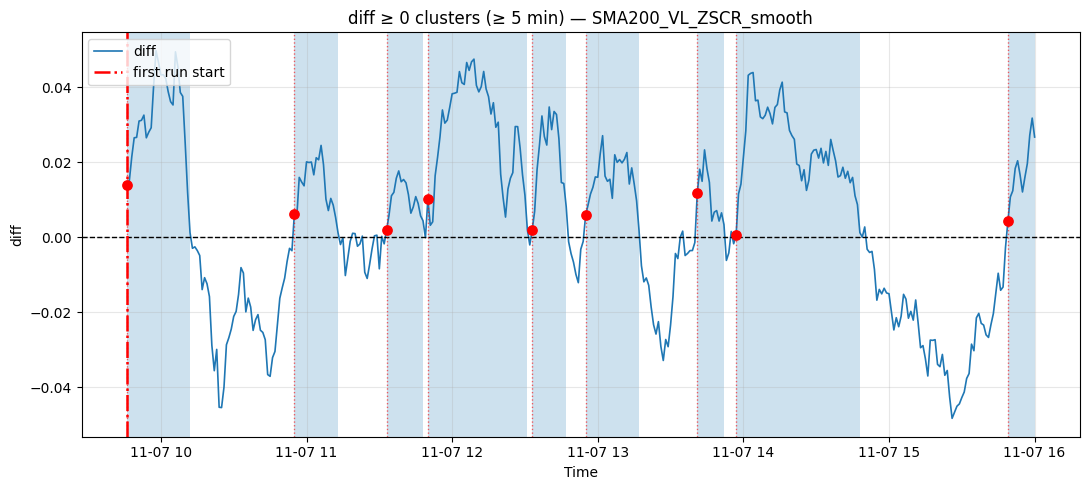

🔁 Auto-refresh at: 2025-11-07 15:38:10.636121
Next refresh in 26s 

In [ ]:



from IPython.display import clear_output
import time
import sys
import pandas as pd  # only if you print timestamps

REFRESH_EVERY = 50  # seconds

def run_analysis():
    # 🔽 Put your entire analysis/plot/table code here
    # Date range 
    start_date = date(2025, 11, 7)
    end_date = date(2025, 11,7)
    
    # Time window for filtering intraday bars (Eastern Time)
    start_time = dt_time(0, 0)   # ex.,4:00 AM ET
    end_time = dt_time(20, 0)    #ex.,4:00 PM ET
    #-------------------------------------------------------------------------------------------------------------------------------------------------------------------
    # Granularity of data
    multiplier = 1               #   e.g., 1-minute bars,  5-minute bars, etc.
    timespan = "minute"          #  "second", "minute", "hour", "day", etc.
    
    # Max number of bars to retrieve per request (Polygon max = 50,000)
    limit = 50000
    
    # ⬇️ Fetch intraday data for multiple tickers from Polygon
    all_data_minute = fetch_multiple_tickers_data(
        ticker=TICKERS,
        api_key=API_KEY,
        start_date=start_date,
        end_date=end_date,
        start_time=start_time,
        end_time=end_time,
        multiplier=multiplier,
        timespan=timespan,
        limit=limit
    )
    
    import talib
    import pandas as pd
    import numpy as np
    import pandas_ta as ta
    from scipy.stats import zscore
    from scipy.signal import savgol_filter
    
    
    
    # TICKERS = ['BULL']
    
    # ─────────────────────────────────────────────────────────────────────
    # Assume all_data_minute is a dict: {"AAPL": df1, "TSLA": df2, ...}
    # and TICKERS is your list of symbols
    # ─────────────────────────────────────────────────────────────────────
    TICKERS_Plot=TICKERS
    
    all_data_minute_processed = {}
    
    for TICKER in TICKERS_Plot:
        df = all_data_minute[TICKER].copy()
    
        # ─────────────── Indicators Setup ───────────────
        # EMPTY FOR NOW
        # ─────────────── Save the processed DataFrame ───────────────
        all_data_minute_processed[TICKER] = df
        #_____________________________________________________________
        
    tickers_to_buy = []
    
    for TICKER in TICKERS:
        if TICKER not in all_data_minute_processed:
            continue
    
        df = all_data_minute_processed[TICKER]
    
        # Confirm it's a DataFrame (not a tuple accidentally)
        if isinstance(df, tuple):
            df = df[0]  # if stored as (df,) in the dictionary
    
        if "buy_condition" in df.columns and df["buy_condition"].any():
            tickers_to_buy.append(TICKER)
    
    # ─────────────────────────────────────────────────────────────────────
    # Do the plot
    # ─────────────────────────────────────────────────────────────────────
    
    for tic in TICKERS:
        df_day = all_data_minute_processed.get(tic)
        if df_day is None or df_day.empty:
            print(f"⚠️ {tic}: no data"); 
            continue
    
        fig = plot_intraday(df=df_day, ticker=tic)
    
        # Show regardless of library
        if hasattr(fig, "show"):          # Plotly Figure or Matplotlib Figure has .show()
            fig.show()
        else:
            try:
                display(fig)              # fallback for objects with rich repr
            except Exception:
                pass
    
    # ─────────────────────────────────────────────────────────────────────
    #Find the turning points
    # ─────────────────────────────────────────────────────────────────────
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    
    # ===== Inputs =====
    start_time = dt_time(9, 0)   # ex.,4:00 AM ET
    end_time = dt_time(16, 0)    #ex.,4:00 PM ET
    start_date = date(2025, 11, 7)
    end_date = date(2025, 11, 7)
    
    time_step  = 5                                # minutes threshold for sustained positivity
    TIME_COL   = "TIME_EST"
    COL        = "SMA200_VL_ZSCR_smooth"
    CLOSE_COL  = "close"                          # assumes df_day has 'close'
    ET_ZONE = ZoneInfo("America/New_York")
    # ===== Prepare window =====
    
    df = df_day.copy()
    df[TIME_COL] = pd.to_datetime(df[TIME_COL], errors="coerce")
    
    start_time = datetime.combine(start_date, start_time, tzinfo=ET_ZONE)
    end_time = datetime.combine(end_date, end_time, tzinfo=ET_ZONE)
    
    cols_to_keep = [TIME_COL, COL] + ([CLOSE_COL] if CLOSE_COL in df.columns else [])
    mask = (df[TIME_COL] >= start_time) & (df[TIME_COL] <= end_time)
    df_window = (
        df.loc[mask, cols_to_keep]
          .copy()
          .set_index(TIME_COL)
          .sort_index()
    )
    df_window = df_window[~df_window.index.duplicated(keep="first")]
    
    # ===== Compute diff =====
    df_window["diff"] = df_window[COL].diff()
    
    # ===== Build runs by sign ONLY (ignore timing gaps) =====
    tmp = df_window["diff"].dropna().to_frame("diff").reset_index(names="ts")
    tmp["grp"] = (tmp["diff"] < 0).cumsum()          # same group while diff ≥ 0
    pos = tmp[tmp["diff"] >= 0]
    
    # start/end = first/last timestamps per positive group
    runs = pos.groupby("grp").agg(run_start=("ts","first"), run_end=("ts","last"))
    runs["duration"] = runs["run_end"] - runs["run_start"]
    
    # keep runs with duration >= time_step minutes
    runs = runs[runs["duration"] >= pd.Timedelta(minutes=time_step)].copy()
    runs["duration_min"] = runs["duration"].dt.total_seconds()/60
    
    # ===== Attach close at run_start/run_end and compute delta/pct =====
    def get_close_exact_or_asof(ts):
        if CLOSE_COL in df_window.columns:
            try:
                return float(df_window.loc[ts, CLOSE_COL])
            except KeyError:
                return float(df_window[CLOSE_COL].asof(ts))
        return np.nan
    
    runs["run_start_close"] = runs["run_start"].map(get_close_exact_or_asof)
    runs["run_end_close"]   = runs["run_end"].map(get_close_exact_or_asof)
    
    runs["delta_close"] = runs["run_end_close"] - runs["run_start_close"]
    runs["pct_change"]  = np.where(
        runs["run_start_close"] != 0,
        (runs["delta_close"] / runs["run_start_close"]) * 100.0,
        np.nan
    )
    
    # Reorder & tidy columns
    runs = runs.reset_index(drop=True)
    summary_cols = [
        "run_start_close", "run_end_close", "delta_close", "pct_change",
        "run_start", "run_end", "duration_min"
    ]
    runs = runs[summary_cols]
    
    # Round for neat display (optional)
    runs_rounded = runs.copy()
    runs_rounded[["run_start_close","run_end_close","delta_close","pct_change","duration_min"]] = \
        runs_rounded[["run_start_close","run_end_close","delta_close","pct_change","duration_min"]].round(4)
    
    print(f"✅ All clusters with diff ≥ 0 for ≥ {time_step} minutes:")
    display(runs_rounded)
    
    # Earliest turning point (start of first qualifying run)
    first_tp = runs_rounded["run_start"].iloc[0] if not runs_rounded.empty else None
    if first_tp is not None:
        print(f"\n🎯 Earliest turning point: {first_tp} | "
              f"close={get_close_exact_or_asof(first_tp):.4f}")
    
    # ===== Plot =====
    fig, ax = plt.subplots(figsize=(11,5))
    ax.plot(df_window.index, df_window["diff"], label="diff", linewidth=1.2)
    ax.axhline(0, color="black", lw=1, ls="--")
    
    # Shade each qualifying run & mark start with red
    for _, r in runs.iterrows():
        ax.axvspan(r["run_start"], r["run_end"], alpha=0.22, label=None)
        y_val = df_window["diff"].get(r["run_start"], 0.0)
        ax.scatter(r["run_start"], y_val, s=45, color="red", zorder=3)
        ax.axvline(r["run_start"], color="red", lw=1, ls=":", alpha=0.6)
    
    # Mark earliest turning point distinctly
    if first_tp is not None:
        ax.axvline(first_tp, color="red", lw=1.8, ls="-.", label="first run start")
    
    ax.set_title(f"diff ≥ 0 clusters (≥ {time_step} min) — {COL}")
    ax.set_xlabel("Time"); ax.set_ylabel("diff")
    ax.grid(True, alpha=0.3)
    ax.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    # (everything up to and including plt.show())
    pass

while True:
    # 1) Run and DISPLAY results
    run_analysis()

    # 2) Keep results visible with a countdown (no clearing yet)
    print("🔁 Auto-refresh at:", pd.Timestamp.now())
    for i in range(REFRESH_EVERY, 0, -1):
        sys.stdout.write(f"\rNext refresh in {i:2d}s ")
        sys.stdout.flush()
        time.sleep(1)

        

    # 3) NOW clear, so next loop starts fresh
    clear_output(wait=True)





In [ ]:
# import pandas as pd

# # ----- Inputs -----
# start_time = dt_time(13, 20)   # ex.,4:00 AM ET
# end_time = dt_time(14, 20)    #ex.,4:00 PM ET
# start_date = date(2025, 10, 30)
# end_date = date(2025, 10, 30)
# ET_ZONE = ZoneInfo("America/New_York")
# start_time = datetime.combine(start_date, start_time, tzinfo=ET_ZONE)
# end_time = datetime.combine(end_date, end_time, tzinfo=ET_ZONE)

# # ----- Extract range from df_day -----
# df_check = df_day.copy()
# df_check[TIME_COL] = pd.to_datetime(df_check[TIME_COL], errors="coerce")

# mask = (df_check[TIME_COL] >= start_time) & (df_check[TIME_COL] <= end_time)
# df_check = df_check.loc[mask, [TIME_COL, COL]]

# # ----- Compute diff -----
# df_check["diff"] = df_check[COL].diff()

# # ----- Display -----
# print(df_check.head(60))   # first 20 rows for preview
# # print(df_check.tail(5))    # last 5 rows for confirmation


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ---------- CONFIG ----------
COL = "SMA200_VL_ZSCR_smooth"
TIME_COL = "TIME_EST"
df=df_day
# ----------------------------

# Ensure TIME_EST is datetime and sorted
df[TIME_COL] = pd.to_datetime(df[TIME_COL], errors="coerce")
df = df.dropna(subset=[TIME_COL]).sort_values(TIME_COL)

daily_summary_rows = []

# Group by calendar day
for day, group in df.groupby(df[TIME_COL].dt.date):
    g = group.set_index(TIME_COL)
    if g[COL].notna().any():
        # find min and max timestamps and values
        min_time = g[COL].idxmin()
        max_time = g[COL].idxmax()
        min_value = float(g.loc[min_time, COL])
        max_value = float(g.loc[max_time, COL])

        # compute absolute time difference in hours
        time_diff_hours = abs((max_time - min_time).total_seconds() / 3600.0)

        # absolute amplitude (|max - min|)
        amplitude_abs = abs(max_value - min_value)

        daily_summary_rows.append({
            "Day": pd.to_datetime(day),
            "Min_of_day": min_value,
            "Min_time": min_time,
            "Max_of_day": max_value,
            "Max_time": max_time,
            "Hours_between_min_and_max": time_diff_hours,
            "Amplitude_abs": amplitude_abs
        })

# Create the summary DataFrame
daily_summary = pd.DataFrame(daily_summary_rows).sort_values("Day").reset_index(drop=True)

# Pretty print settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.3f}'.format)

display(daily_summary)

# ---------- PLOTTING HELPERS ----------
def _format_date_axis(ax):
    locator = mdates.AutoDateLocator()
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

def _add_hlines(ax, series, add_legend=True):
    avg_val = float(series.mean())
    med_val = float(series.median())
    ax.axhline(avg_val, linestyle='--', linewidth=1, label=f'Avg ({avg_val:.3f})')
    ax.axhline(med_val, linestyle=':', linewidth=1, label=f'Median ({med_val:.3f})')
    if add_legend:
        ax.legend()

# ---------- FIGURE 1: Daily Min ----------
fig1, ax1 = plt.subplots()
ax1.scatter(daily_summary["Day"], daily_summary["Min_of_day"])
_add_hlines(ax1, daily_summary["Min_of_day"])
ax1.set_title(f"Daily Min of {COL}")
ax1.set_xlabel("Day")
ax1.set_ylabel("Min_of_day")
_format_date_axis(ax1)
ax1.grid(True)
plt.tight_layout()

# ---------- FIGURE 2: Daily Max ----------
fig2, ax2 = plt.subplots()
ax2.scatter(daily_summary["Day"], daily_summary["Max_of_day"])
_add_hlines(ax2, daily_summary["Max_of_day"])
ax2.set_title(f"Daily Max of {COL}")
ax2.set_xlabel("Day")
ax2.set_ylabel("Max_of_day")
_format_date_axis(ax2)
ax2.grid(True)
plt.tight_layout()

# ---------- FIGURE 3: Daily Amplitude_abs ----------
fig3, ax3 = plt.subplots()
ax3.scatter(daily_summary["Day"], daily_summary["Amplitude_abs"])
_add_hlines(ax3, daily_summary["Amplitude_abs"])
ax3.set_title(f"Daily |Max-Min| Amplitude of {COL}")
ax3.set_xlabel("Day")
ax3.set_ylabel("Amplitude_abs")
_format_date_axis(ax3)
ax3.grid(True)
plt.tight_layout()


In [ ]:
# pip install plotly  # <- run once if needed

import numpy as np
import pandas as pd
import plotly.graph_objects as go

df = df_day
# ---------- CONFIG ----------
COL = "SMA200_VL_ZSCR_smooth"
TIME_COL = "TIME_EST"
# ----------------------------

# Ensure TIME_EST is datetime and sorted
df[TIME_COL] = pd.to_datetime(df[TIME_COL], errors="coerce")
df = df.dropna(subset=[TIME_COL]).sort_values(TIME_COL)

# --- Collect daily extrema (min & max per day) ---
daily_extrema_rows = []
for day, group in df.groupby(df[TIME_COL].dt.date):
    g = group.set_index(TIME_COL)
    if g[COL].notna().any():
        min_ts = g[COL].idxmin()
        max_ts = g[COL].idxmax()
        min_val = g.loc[min_ts, COL]
        max_val = g.loc[max_ts, COL]
        daily_extrema_rows.append({
            "day": pd.to_datetime(day),
            "min_time": min_ts, "min_value": min_val,
            "max_time": max_ts, "max_value": max_val,
            "amplitude_abs": abs(max_val - min_val),
            "day_mid": pd.to_datetime(day) + pd.Timedelta(hours=12),
        })

daily_extrema = pd.DataFrame(daily_extrema_rows)

# --- Compute mean & median lines ---
mean_min = daily_extrema["min_value"].mean() if not daily_extrema.empty else None
median_min = daily_extrema["min_value"].median() if not daily_extrema.empty else None
mean_max = daily_extrema["max_value"].mean() if not daily_extrema.empty else None
median_max = daily_extrema["max_value"].median() if not daily_extrema.empty else None
mean_amp = daily_extrema["amplitude_abs"].mean() if not daily_extrema.empty else None
median_amp = daily_extrema["amplitude_abs"].median() if not daily_extrema.empty else None

# --- Build interactive figure ---
fig = go.Figure()

# Main series
fig.add_trace(go.Scatter(
    x=df[TIME_COL], y=df[COL],
    mode="lines", name=COL,
    hovertemplate="%{x|%Y-%m-%d %H:%M:%S}<br>%{y:.4f}<extra></extra>"
))

# Daily mins and maxes
if not daily_extrema.empty:
    fig.add_trace(go.Scatter(
        x=daily_extrema["min_time"], y=daily_extrema["min_value"],
        mode="markers", name="Daily min",
        marker=dict(size=9, symbol="triangle-down", color="blue"),
        hovertemplate="%{x|%Y-%m-%d %H:%M:%S}<br>%{y:.4f}<extra></extra>"
    ))
    fig.add_trace(go.Scatter(
        x=daily_extrema["max_time"], y=daily_extrema["max_value"],
        mode="markers", name="Daily max",
        marker=dict(size=9, symbol="triangle-up", color="red"),
        hovertemplate="%{x|%Y-%m-%d %H:%M:%S}<br>%{y:.4f}<extra></extra>"
    ))

# --- Horizontal reference lines for min/max mean & median ---
if mean_min is not None:
    fig.add_hline(y=mean_min, line=dict(color="green", width=1.5, dash="dash"),
                  annotation_text=f"Mean of daily mins = {mean_min:.4f}",
                  annotation_position="top left")
if median_min is not None:
    fig.add_hline(y=median_min, line=dict(color="green", width=1.5, dash="dot"),
                  annotation_text=f"Median of daily mins = {median_min:.4f}",
                  annotation_position="bottom left")
if mean_max is not None:
    fig.add_hline(y=mean_max, line=dict(color="red", width=1.5, dash="dash"),
                  annotation_text=f"Mean of daily maxes = {mean_max:.4f}",
                  annotation_position="top right")
if median_max is not None:
    fig.add_hline(y=median_max, line=dict(color="red", width=1.5, dash="dot"),
                  annotation_text=f"Median of daily maxes = {median_max:.4f}",
                  annotation_position="bottom right")

# --- Amplitude labels above each day’s max ---
if not daily_extrema.empty:
    y_series = df[COL].dropna()
    y_pad = 0.02 * (y_series.max() - y_series.min()) if len(y_series) else 0.1
    annotations = []
    for _, r in daily_extrema.iterrows():
        annotations.append(dict(
            x=r["day_mid"],
            y=r["max_value"] + y_pad,
            xref="x", yref="y",
            text=f"{r['amplitude_abs']:.3f}",
            showarrow=False,
            align="center",
            yanchor="bottom",
            font=dict(size=10, color="black"),
            bgcolor="rgba(255,255,255,0.7)",
            bordercolor="rgba(0,0,0,0.25)",
            borderwidth=1
        ))
    fig.update_layout(annotations=annotations)

# --- Add amplitude mean/median horizontal lines (black) ---
if mean_amp is not None:
    fig.add_hline(
        y=mean_amp, line=dict(color="black", width=1.2, dash="dash"),
        annotation_text=f"Mean amplitude = {mean_amp:.3f}",
        annotation_position="top left"
    )
if median_amp is not None:
    fig.add_hline(
        y=median_amp, line=dict(color="black", width=1.2, dash="dot"),
        annotation_text=f"Median amplitude = {median_amp:.3f}",
        annotation_position="bottom left"
    )

# --- Layout: white background, light gray gridlines, no range selector buttons ---
fig.update_layout(
    title=f"{COL} — Daily Extrema + Mean/Median + Amplitude Lines",
    xaxis_title="Time (EST)",
    yaxis_title=COL,
    hovermode="x unified",
    plot_bgcolor="white",      # ✅ white background
    paper_bgcolor="white",     # ✅ white paper background
    xaxis=dict(
        showgrid=True,
        gridcolor="lightgray",
        rangeslider=dict(visible=True),   # ✅ keep lower scroll bar
        type="date",
        showspikes=True,
        spikemode="across"
    ),
    yaxis=dict(
        showgrid=True,
        gridcolor="lightgray",
        showspikes=True,
        spikemode="across"
    ),
    margin=dict(l=60, r=20, t=80, b=40),
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="left", x=0)
)

fig.show()


In [ ]:
# terminal
!pip install python-dotenv
!pip install --upgrade pip

In [ ]:
# === Edit these ===
THRESHOLD = 3.0                 # your threshold (number)
CURRENT_VALUE = 3.25            # paste the current value manually here

# Condition: change operator as you like: '>', '>=', '<', '<='
OPERATOR = '>='                 # send alert if CURRENT_VALUE >= THRESHOLD

# Sender (Gmail with App Password)
SMTP_SERVER="smtp.gmail.com"
SMTP_PORT=587
SENDER_EMAIL="sharifarnaz@gmail.com"
SENDER_APP_PASSWORD="wjfckkeldldurjev"

# Recipients: email(s) and/or Verizon SMS gateway (1234567890@vtext.com)
RECIPIENTS = [
    "sharifarnaz@gmail.com",
    "6468998361@vtext.com",     # Verizon SMS (short), use @vzwpix.com for longer MMS
]

# --- Do not edit below (helper to evaluate the condition) ---
def condition_met(val, op, thr):
    if op == '>':  return val >  thr
    if op == '>=': return val >= thr
    if op == '<':  return val <  thr
    if op == '<=': return val <= thr
    raise ValueError("OPERATOR must be one of: '>', '>=', '<', '<='")

SHOULD_ALERT = condition_met(CURRENT_VALUE, OPERATOR, THRESHOLD)
print(f"Condition: {CURRENT_VALUE} {OPERATOR} {THRESHOLD}  ->  {SHOULD_ALERT}")


In [ ]:
import smtplib
from email.mime.text import MIMEText
from datetime import datetime

# === Edit your message here ===
SUBJECT = "ALERT: Threshold hit"
BODY = (
    f"Threshold: {THRESHOLD}\n"
    f"Current value: {CURRENT_VALUE}\n"
    f"Condition: {CURRENT_VALUE} {OPERATOR} {THRESHOLD}\n"
    f"Time: {datetime.now():%Y-%m-%d %H:%M:%S}"
)

def send_alert(subject: str, body: str, recipients: list):
    msg = MIMEText(body)
    msg["From"] = SENDER_EMAIL
    msg["To"] = ", ".join(recipients)
    msg["Subject"] = subject

    with smtplib.SMTP(SMTP_SERVER, SMTP_PORT) as server:
        server.starttls()
        server.login(SENDER_EMAIL, SENDER_APP_PASSWORD)
        server.sendmail(SENDER_EMAIL, recipients, msg.as_string())

if SHOULD_ALERT:
    send_alert(SUBJECT, BODY, RECIPIENTS)
    print("✅ Alert sent.")
else:
    print("No alert — condition not met.")


In [ ]:
# === Verizon SMS recipient ===
VERIZON_NUMBER = "6468998361"                     # <-- put ONLY your 10 digits here
VERIZON_SMS = f"{VERIZON_NUMBER}@vtext.com"       # SMS gateway (160 char limit)

# === Your short test message (86 chars is fine) ===
TEST_BODY = (
    "Threshold: 3.0\n"
    "Current value: 3.25\n"
    "Condition: 3.25 >= 3.0\n"
    "Time: 2025-10-27 14:54:08"
)

# Quick sanity checks
print("Sending to:", VERIZON_SMS)
print("Message length:", len(TEST_BODY), "chars (<=160 OK)")


In [ ]:
import smtplib
from email.mime.text import MIMEText

# Optional: turn on SMTP debug output (1 = verbose, 0 = quiet)
SMTP_DEBUG = 1

msg = MIMEText(TEST_BODY)
msg["From"] = SENDER_EMAIL
msg["To"] = VERIZON_SMS
msg["Subject"] = ""  # keep empty for @vtext.com

try:
    with smtplib.SMTP(SMTP_SERVER, SMTP_PORT) as server:
        server.set_debuglevel(SMTP_DEBUG)
        server.starttls()
        server.login(SENDER_EMAIL, SENDER_APP_PASSWORD)
        server.sendmail(SENDER_EMAIL, [VERIZON_SMS], msg.as_string())
    print("✅ SMS sent to", VERIZON_SMS)
except Exception as e:
    print("❌ Send failed:", repr(e))


In [ ]:
import smtplib
from email.mime.text import MIMEText

SMTP_SERVER = "smtp.gmail.com"
SMTP_PORT = 587
SENDER_EMAIL = "your_email@gmail.com"
SENDER_APP_PASSWORD = "your_16_char_app_password"
NUMBER = "6468998361"  # <-- your 10 digits

BODY = (
    "Threshold: 3.0\n"
    "Current value: 3.25\n"
    "Condition: 3.25 >= 3.0\n"
    "Time: 2025-10-27 14:54:08"
)

def _send(to_addr, body):
    msg = MIMEText(body)
    msg["From"] = SENDER_EMAIL
    msg["To"] = to_addr
    msg["Subject"] = ""  # MUST be empty for SMS
    with smtplib.SMTP(SMTP_SERVER, SMTP_PORT) as server:
        server.starttls()
        server.login(SENDER_EMAIL, SENDER_APP_PASSWORD)
        server.sendmail(SENDER_EMAIL, [to_addr], msg.as_string())

# 1) Try SMS gateway
try:
    sms_addr = f"{NUMBER}@vtext.com"
    short_body = BODY[:150]  # keep well under 160
    _send(sms_addr, short_body)
    print("Sent via SMS gateway:", sms_addr, "| length:", len(short_body))
except Exception as e:
    print("SMS gateway send error:", repr(e))

# 2) Try MMS gateway (often more reliable)
try:
    mms_addr = f"{NUMBER}@vzwpix.com"
    _send(mms_addr, BODY)  # MMS can handle longer and sometimes delivers when SMS doesn’t
    print("Sent via MMS gateway:", mms_addr, "| length:", len(BODY))
except Exception as e:
    print("MMS gateway send error:", repr(e))
